# Оптимизация маркетинговых затрат в Яндекс.Афише

## Описание проекта
В отделе аналитики Яндекс.Афиши стоит задача  помочь маркетологам оптимизировать маркетинговые затраты.

В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши `visits`,
- выгрузка всех заказов за этот период `orders`,
- статистика рекламных расходов `costs`.

Предстоит выяснить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

### Описание данных
Таблица `visits` (лог сервера с информацией о посещениях сайта):
- *Uid* — уникальный идентификатор пользователя
- *Device* — категория устройства пользователя
- *Start Ts* — дата и время начала сессии
- *End Ts* — дата и время окончания сессии
- *Source Id* — идентификатор рекламного источника, из которого пришел пользователь

Таблица `orders` (информация о заказах):
- *Uid* — уникальный id пользователя, который сделал заказ
- *Buy Ts* — дата и время заказа
- *Revenue* — выручка Яндекс.Афиши с этого заказа

Таблица `costs` (информация о затратах на маркетинг):
- *source_id* — идентификатор рекламного источника
- *dt* — дата
- *costs* — затраты на этот рекламный источник в этот день

## План исследования

[Загрузка данных и подготовка к анализу](#section_1)

[Продукт](#section_2)
- [Сколько людей пользуются в день, неделю, месяц?](#section_2)
- [Сколько сессий в день?](#section_3)
- [Продолжительность сессии](#section_4)
- [Retention Rate](#section_5)

[Продажи](#section_6)
- [Когда люди начинают покупать?](#section_6)
- [Сколько раз покупают за период?](#section_7)
- [Средний чек](#section_8)
- [Сколько денег приносят? (LTV)](#section_9)

[Маркетинг](#section_10)
- [Сколько денег потратили?](#section_10)
- [Сколько стоило привлечение одного покупателя из каждого источника?](#section_11)
- [На сколько окупились расходы? (ROI)](#section_12)

[Выводы и рекомендации](#section_13)

### Загрузка данных и подготовка к анализу <a id='section_1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
matplotlib.rcParams['xtick.minor.visible'] = True

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Создадим функцию для полученяи базовой информации по датавреймам и применим ее

In [3]:
def df_allinfo(df):
    '''базовая информация по датафрейму'''
    df.info()
    display(df.describe())
    display(df.head())  

In [4]:
df_allinfo(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


- По первому взгляду на датафрейм с логами визитов видим, что тип данных с датами не приведен к соответсвующему типу. 
- Также, видим, что названия столбцов не соответсвуют стандарту PEP8.
- Пропуски отсутствуют.

Создадим функцию для преобразования названий колонок к нижнему регистру без пробелов

In [5]:
def str_transform(string):
    '''
        преобразование строки к нижнему регистру
        замена пробелов на "_"
    '''
    return string.replace(' ', '_').lower()

Преобразуем названия колонок

In [6]:
visits.columns = map(str_transform, visits.columns)
display(visits.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Приведем данные с датами и ременем к соответвующему типу

In [7]:
visits = visits.\
            assign(end_ts = lambda x: pd.to_datetime(x['end_ts'], format='%Y-%m-%dT%H:%M:%S'),
                   start_ts = lambda x: pd.to_datetime(x['start_ts'], format='%Y-%m-%dT%H:%M:%S'))

Проверим данные в других стоблбацах на корректность, а также наличие дубликатов:

In [8]:
display(visits['source_id'].unique())
display(visits['device'].unique())
print('Дубликаты:', visits.duplicated().sum())

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

array(['touch', 'desktop'], dtype=object)

Дубликаты: 0


Проверим корректность времени визитов

In [9]:
visits.query('start_ts > end_ts')

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Как видим, в данных содержатся некорректные данные, где, дата начала визита позже его окончания. Очистим датафрейм от таких строк:

In [10]:
visits = visits.query('~(start_ts > end_ts)')

Проверим базовую информацию по логам заказов

In [11]:
df_allinfo(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Аналогичная проблема с форматами дат и столбцами. Преобразуем:

In [12]:
orders.columns = map(str_transform, orders.columns)
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%dT%H:%M:%S')
orders.sample(5)

,buy_ts,revenue,uid
14515,2017-10-25 14:28:00,5.50,3601099419845979773
7838,2017-09-15 09:52:00,4.28,12593176124809752646
1809,2017-06-22 20:09:00,0.73,15081845564351847217
34220,2018-02-11 20:42:00,8.62,13219536335896160750
13481,2017-10-18 21:24:00,6.11,12715883389642441051


Проверим базовую информацию по маркетинговым издержкам:

In [13]:
df_allinfo(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


- Пропуски отсутствуют
- Есть проблема с форматом даты

Преобразуем столбец с датами, а также для наглядности переименуем его.

In [14]:
costs = costs.rename(columns={"dt": "date"})
costs['date'] = pd.to_datetime(costs['date'])

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Итоги предобработки
На этапе предобработки были обнаружены и исправлены данные с форматами дат, проверены дубликаты, а также переименованы названия столбцов к единому удобочитаемому стандарту.

 ## Продукт <a id='section_2'></a>

### Сколько людей пользуются в день, неделю, месяц?

В датафрейм с физитами добавим столбцы по дням/неделям/месяцам сессий для расчета определенных метрик: 

In [15]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date
354819,desktop,2017-10-07 19:24:00,9,2017-10-07 19:22:00,4601284777720506836,2017-10-01,2017-10-05,2017-10-07
267510,desktop,2017-12-06 12:53:00,3,2017-12-06 12:49:00,15080565116076032264,2017-12-01,2017-11-30,2017-12-06
127215,desktop,2018-05-24 10:39:00,5,2018-05-24 10:34:00,4955452210521594707,2018-05-01,2018-05-24,2018-05-24
120959,desktop,2017-07-19 16:50:00,5,2017-07-19 16:42:00,14891103290339989063,2017-07-01,2017-07-13,2017-07-19
131491,touch,2018-01-25 12:38:00,2,2018-01-25 12:32:00,491803876815330476,2018-01-01,2018-01-25,2018-01-25


In [16]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359398 entries, 0 to 359399
Data columns (total 8 columns):
device           359398 non-null object
end_ts           359398 non-null datetime64[ns]
source_id        359398 non-null int64
start_ts         359398 non-null datetime64[ns]
uid              359398 non-null uint64
session_month    359398 non-null datetime64[ns]
session_week     359398 non-null datetime64[ns]
session_date     359398 non-null datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(1), uint64(1)
memory usage: 24.7+ MB


Посчитаем метрики. Для этого сгруппируем данные по соответсвующей периодичности и посчитаем уникальных посетителей

In [17]:
dau = visits.groupby('session_date').agg({'uid' : 'nunique'}).mean()
wau = visits.groupby(['session_week']).agg({'uid' : 'nunique'}).mean()
mau = visits.groupby(['session_month']).agg({'uid' : 'nunique'}).mean()

print('Среднее значение DAU:', int(dau))
print('Среднее значение WAU:', int(wau))
print('Среднее значение MAU:', int(mau))

Среднее значение DAU: 907
Среднее значение WAU: 5724
Среднее значение MAU: 23228


Проанализируем регулярность использования сервиса Яндекс.Афиша с помощью метрики **sticky factor**

In [18]:
sticky_wau = float(dau / wau)
sticky_mau = float(dau / mau)

print('В среднем в неделю регулярно посещают Яндекс.Афишу {:.2%} пользователей'.format(sticky_wau))
print('В среднем в месяц регулярно посещают Яндекс.Афишу {:.2%} пользователей'.format(sticky_mau))

В среднем в неделю регулярно посещают Яндекс.Афишу 15.86% пользователей
В среднем в месяц регулярно посещают Яндекс.Афишу 3.91% пользователей


Видим, что пользователи в более короткие промежутки времени могут обращаться к сервису Яндекс.Афиши несколько раз. А вот регулярность пользования сервисом на протяжении месяца характеризуется низким показателем, что говорит о том, что большинство пользователей вряд ли покупают билеты на мероприятия чаще одного раза в месяц.

Построим графики, отражающие количество уникальных посетителей в различные временные периоды, предварительно создав вспомогательный словарь.

In [19]:
dict_period = {'session_date' : ['по дням', 'Дни посещения'],
               'session_week' : ['по неделям', 'Неделя посещения'],
               'session_month' : ['по месяцам', 'Месяц посещения']}

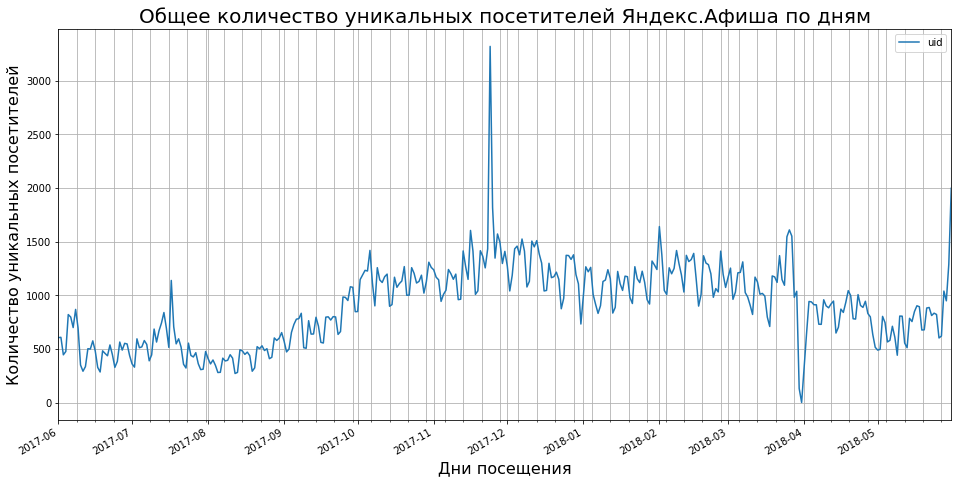

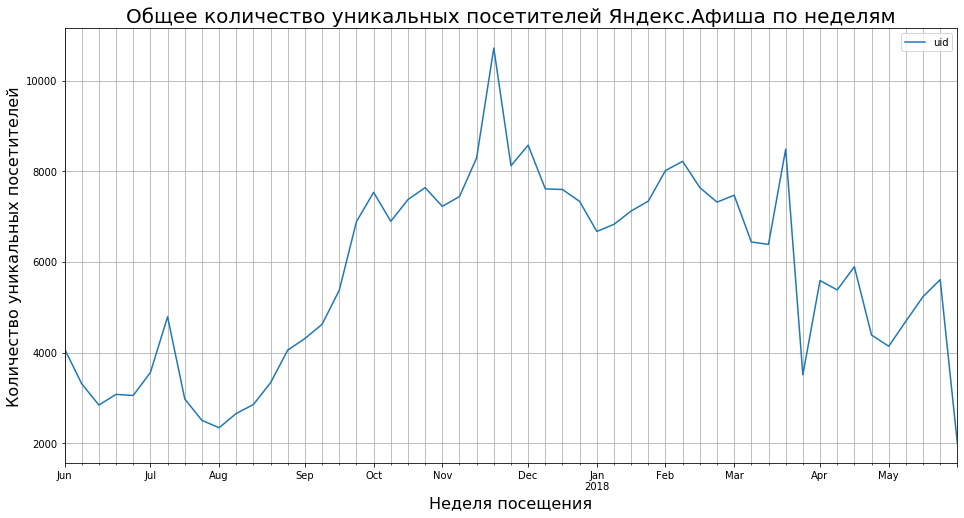

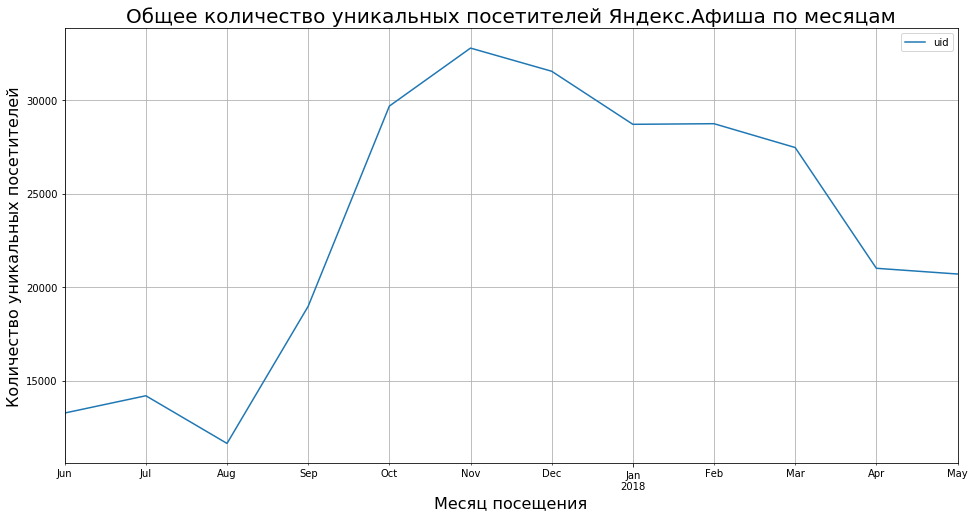

In [20]:
for period in dict_period:
    visits.pivot_table(index=period, values='uid', aggfunc={'uid':'nunique'}).plot(figsize=(16,8), grid=True)
    plt.title('Общее количество уникальных посетителей Яндекс.Афиша {}'.format(dict_period[period][0]), fontsize=20)
    plt.xlabel(dict_period[period][1], fontsize=16)
    plt.ylabel('Количество уникальных посетителей', fontsize=16)
    #plt.xticks(np.arange(pd.to_datetime('2017-06-01'), pd.to_datetime('2018-05-31'), pd.to_timedelta('5 day')), rotation=0, fontsize=8)
    plt.show()

Статистика уникальных пользователей указывает на максимальный приток пользователей в последний квартал года, что, возможно, связано увеличением спроса в связи с большим количеством коцертных мероприятий в пред- и постпраздничный период. 

При этом в летний период (в период отпусков) спрос на подобные мероприятия предположительно снижается. Однако, это лишь гипотеза, требующая более детального изучения в ретроспективе нескольких лет.

Посмотрим, на количество уникальных пользователей в разрезе устройств пользователей.

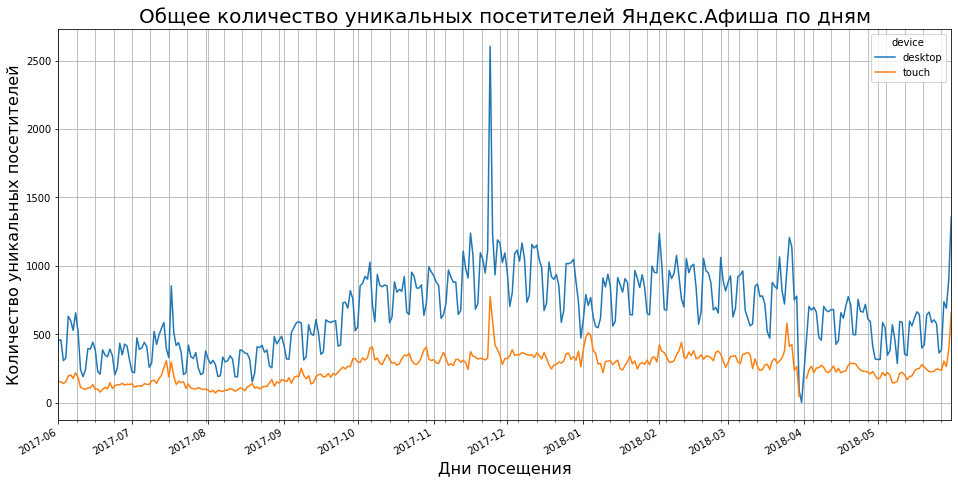

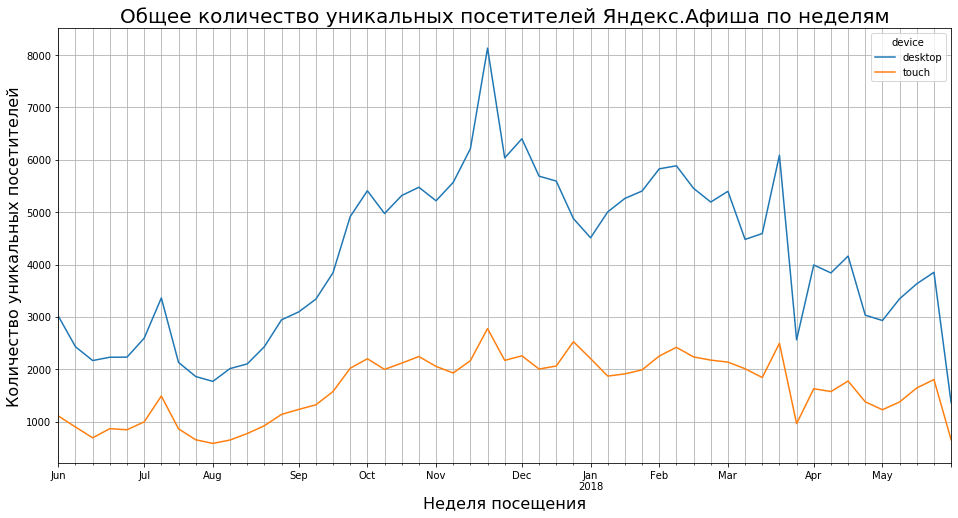

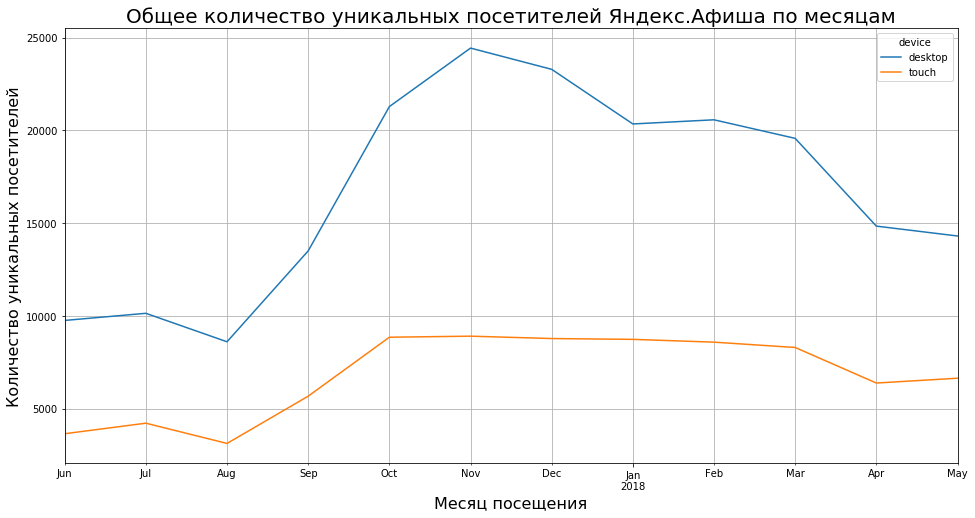

In [21]:
for period in dict_period:
    visits.pivot_table(index=period, columns='device', values='uid',  aggfunc='nunique').plot(figsize=(16,8), grid=True)
    plt.title('Общее количество уникальных посетителей Яндекс.Афиша {}'.format(dict_period[period][0]), fontsize=20)
    plt.xlabel(dict_period[period][1], fontsize=16)
    plt.ylabel('Количество уникальных посетителей', fontsize=16)
    #plt.xticks(np.arange(pd.to_datetime('2017-06-01'), pd.to_datetime('2018-05-31'), pd.to_timedelta('5 day')), rotation=0, fontsize=8)
    plt.show()

Видим, что на протяжении последенго года преобладает количество уникальных пользователей с десктопных версий сайта. При этом по характеру кривых заметна положительная корреляция количества уникальных пользователей с двух типов устройств.

Посмотрим из каких источников приходило больще всего уникальных пользователей за последний год

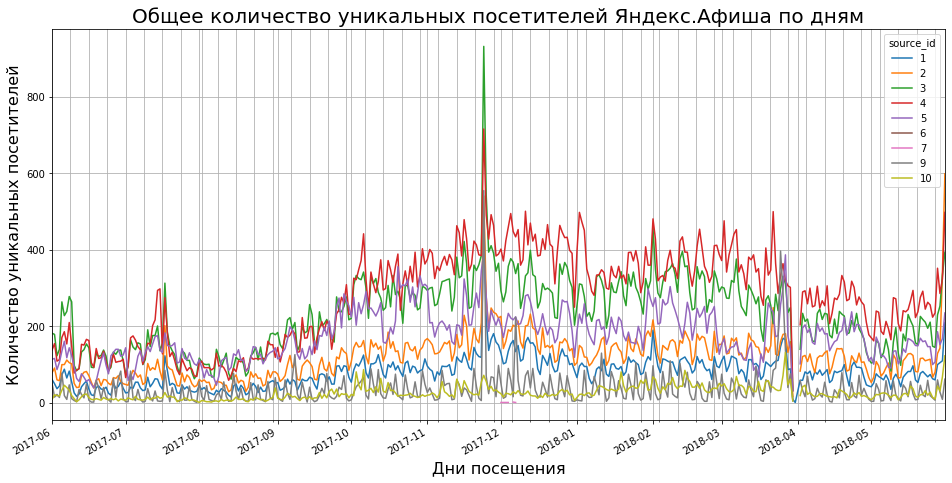

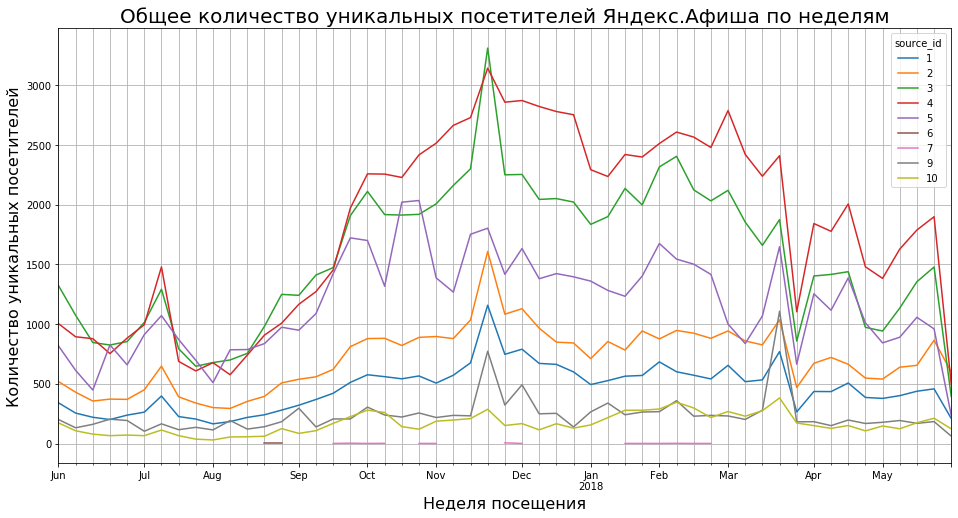

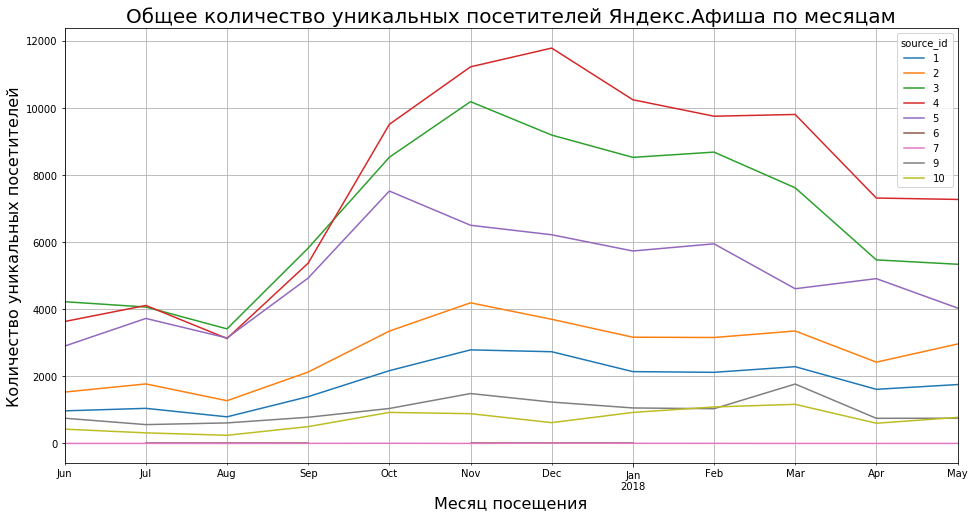

In [22]:
for period in dict_period:
    visits.pivot_table(index=period, columns='source_id', values='uid',  aggfunc={'uid':'nunique'}).plot(figsize=(16,8), grid=True)
    plt.title('Общее количество уникальных посетителей Яндекс.Афиша {}'.format(dict_period[period][0]), fontsize=20)
    plt.xlabel(dict_period[period][1], fontsize=16)
    plt.ylabel('Количество уникальных посетителей', fontsize=16)
    #plt.xticks(np.arange(pd.to_datetime('2017-06-01'), pd.to_datetime('2018-05-31'), pd.to_timedelta('5 day')), rotation=0, fontsize=8)
    plt.show()

Бросается в глаза нестабильность и крайне низкий прирост уникальных пользователей из источника №7.
Также можно выделить тренд, что с июня по октябрь 2017 года источники 3-4-5 демонстрировали примерно одинаковый прирост по уникальным пользователям, но в последующих периодах заметен разрыв и преобладание 4, 3, 5 источников (указаны в порядке убывания). В разрезе недель ситуация соответсвовала помесячной динамике, в то время как по дням ситуация менялась более стремительно. 

### Сколько сессий в день? <a id='section_3'></a>

In [23]:
sessions_per_user = visits.groupby('session_date').agg(n_users = ('uid', 'nunique'),\
                                                       n_sessions = ('uid', 'count'))
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print('Среднее кол-во сессий на 1-го пользователя в день:', round((sessions_per_user['sess_per_user'].mean()),2))

Среднее кол-во сессий на 1-го пользователя в день: 1.08


В подавляющем большинстве пользователи обращаются к сервису Яндекс.Афиша не чаще одного раза в день

### Продолжительность сессии <a id='section_4'></a>

In [24]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

print('Мода:', float(visits['session_duration_sec'].mode()))
print('Медиана:', float(visits['session_duration_sec'].median()))
print('Среднее:', round(float(visits['session_duration_sec'].mean()), 1))


Мода: 60.0
Медиана: 300.0
Среднее: 643.0


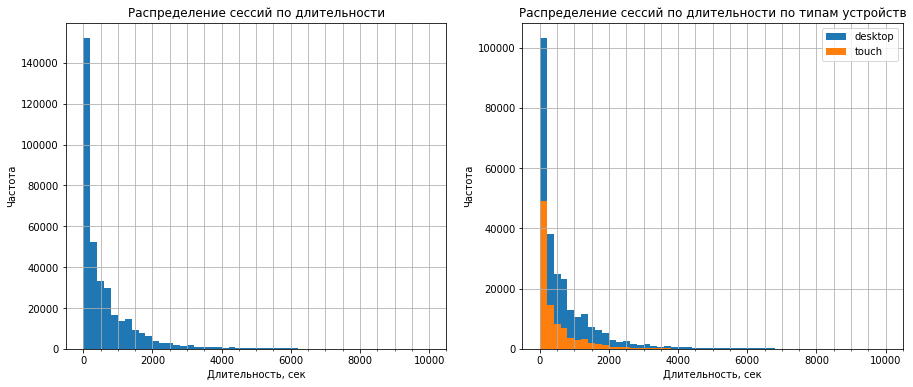

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.hist(visits['session_duration_sec'], bins=50, range=(0,10000))
ax1.set_title('Распределение сессий по длительности')
ax1.set_xlabel('Длительность, сек')
ax1.set_ylabel('Частота')

ax2.hist(visits.query('device == "desktop"')['session_duration_sec'], bins=50, range=(0,10000), label='desktop')
ax2.hist(visits.query('device == "touch"')['session_duration_sec'], bins=50, range=(0,10000), label='touch')
ax2.set_title('Распределение сессий по длительности по типам устройств')
ax2.set_xlabel('Длительность, сек')
ax2.set_ylabel('Частота')
ax2.legend()

plt.show()

In [26]:
print('desktop - мода: {:.1f} сек'.format(float(visits.query('device == "desktop"')['session_duration_sec'].mode())))
print('touch - мода: {:.1f} сек'. format(float(visits.query('device == "touch"')['session_duration_sec'].mode())))

desktop - мода: 60.0 сек
touch - мода: 60.0 сек


Учитывая характер распределения длительности сессий, в качестве средней величины возьмем моду, во избежание искажения (различия с медианой и ср.арф: в 5 и 10 раз соответственно). За среднюю продолжительность сессии примем **60 секунд**.

### Retention Rate <a id='section_5'></a>

Показатель регулярнгости использования сервиса sticky factor показал, что пользователи редко пользуются сервисом чаще одоного раза в месяц. Поэтому в качестве периода для определения когорты возьмем месячный интервал. Определим месяц первого посещения пользователя для формирования когорты. Для этого сформируем отдельный датафрейм с нужной нам датой и присоединим к исходному датафрейму с визитами.

In [27]:
first_activity_date = visits.groupby('uid')['session_month'].min()
first_activity_date.name = 'first_activity_month'
visits = visits.join(first_activity_date, on='uid', how='left')
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359398 entries, 0 to 359399
Data columns (total 10 columns):
device                  359398 non-null object
end_ts                  359398 non-null datetime64[ns]
source_id               359398 non-null int64
start_ts                359398 non-null datetime64[ns]
uid                     359398 non-null uint64
session_month           359398 non-null datetime64[ns]
session_week            359398 non-null datetime64[ns]
session_date            359398 non-null datetime64[ns]
session_duration_sec    359398 non-null int64
first_activity_month    359398 non-null datetime64[ns]
dtypes: datetime64[ns](6), int64(2), object(1), uint64(1)
memory usage: 40.2+ MB


Каждой записи рассчитаем lifetime

In [28]:
visits['cohort_lifetime'] = (visits['session_month'] - visits['first_activity_month']) / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:

In [29]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime', 'device']).agg({'uid' : 'nunique'}).reset_index()
cohorts.head()

,first_activity_month,cohort_lifetime,device,uid
0,2017-06-01,0,desktop,9761
1,2017-06-01,0,touch,3655
2,2017-06-01,1,desktop,833
3,2017-06-01,1,touch,241
4,2017-06-01,2,desktop,593


Рассчитаем первоначальное количество пользоваталетей для каждой когорты

In [30]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid', 'device']]
initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})
initial_users_count

,first_activity_month,cohort_users,device
0,2017-06-01,9761,desktop
1,2017-06-01,3655,touch
24,2017-07-01,9312,desktop
25,2017-07-01,3982,touch
46,2017-08-01,7450,desktop
47,2017-08-01,2796,touch
66,2017-09-01,11715,desktop
67,2017-09-01,5133,touch
84,2017-10-01,18451,desktop
85,2017-10-01,7850,touch


Объединим данные по когортам с исходным количеством пользователей в когорте.

In [31]:
cohorts = cohorts.merge(initial_users_count, on=['first_activity_month', 'device'])
cohorts.head()

,first_activity_month,cohort_lifetime,device,uid,cohort_users
0,2017-06-01,0,desktop,9761,9761
1,2017-06-01,1,desktop,833,9761
2,2017-06-01,2,desktop,593,9761
3,2017-06-01,3,desktop,671,9761
4,2017-06-01,4,desktop,741,9761


Рассчитаем **Retention Rate** для каждого месяца каждой из когорт

In [32]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts.head()

,first_activity_month,cohort_lifetime,device,uid,cohort_users,retention
0,2017-06-01,0,desktop,9761,9761,1.000000
1,2017-06-01,1,desktop,833,9761,0.085340
2,2017-06-01,2,desktop,593,9761,0.060752
3,2017-06-01,3,desktop,671,9761,0.068743
4,2017-06-01,4,desktop,741,9761,0.075914


Построим сводную таблицу, на основании которой можно будет отобразить тепловую карту

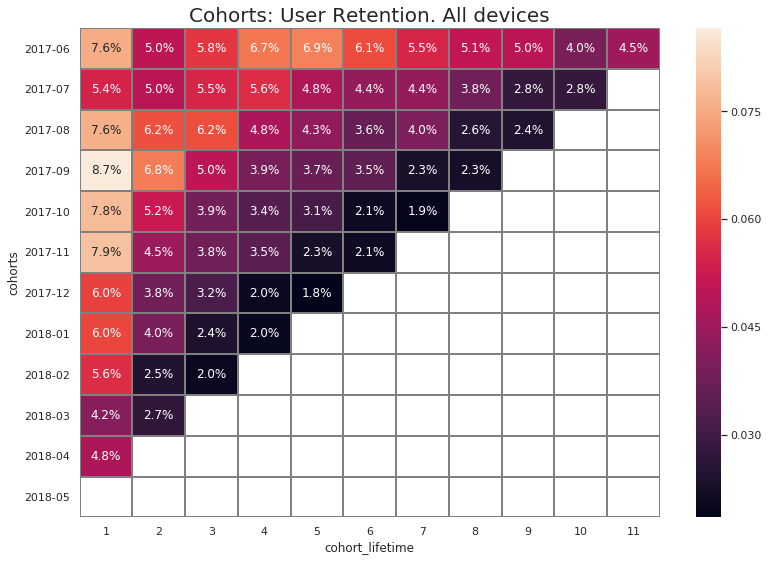

In [33]:
retention_pivot = cohorts.pivot_table(index='first_activity_month', 
                                      columns='cohort_lifetime', 
                                      values='retention')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention. All devices', fontsize=20)
sns.heatmap(retention_pivot.iloc[:, 1:], annot=True, fmt='.1%', linewidths=1, linecolor='gray', 
            yticklabels = retention_pivot.index.strftime('%Y-%m'))
plt.ylabel('cohorts')
plt.show()

In [34]:
print('Средний показатель удержания пользователей Яндекс.Афиша во второй месяц на всех устройствах {:.1%}'.\
      format(retention_pivot.iloc[:, 1].mean()))

Средний показатель удержания пользователей Яндекс.Афиша во второй месяц на всех устройствах 6.5%


Средний показатель удержания пользователей Яндекс.Афиша во второй месяц на DESKTOP-устройствах 6.8%


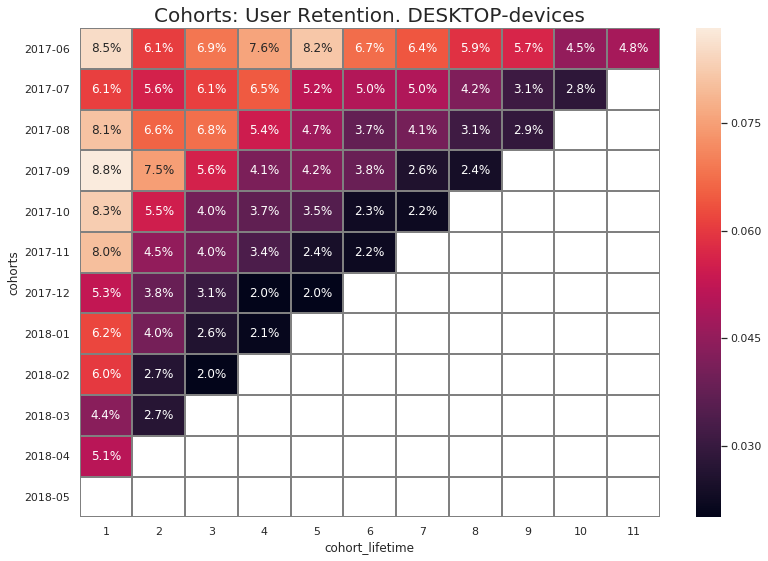

In [35]:
desktop_retention_pivot = cohorts.query('device == "desktop"').\
                            pivot_table(index='first_activity_month', 
                                        columns='cohort_lifetime', 
                                        values='retention')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention. DESKTOP-devices', fontsize=20)
sns.heatmap(desktop_retention_pivot.iloc[:, 1:], annot=True, fmt='.1%', linewidths=1, linecolor='gray', 
            yticklabels = retention_pivot.index.strftime('%Y-%m'))
plt.ylabel('cohorts')

print('Средний показатель удержания пользователей Яндекс.Афиша во второй месяц на DESKTOP-устройствах {:.1%}'.\
      format(desktop_retention_pivot.iloc[:, 1].mean()))

Средний показатель удержания пользователей Яндекс.Афиша во второй месяц на TOUCH-устройствах 6.2%


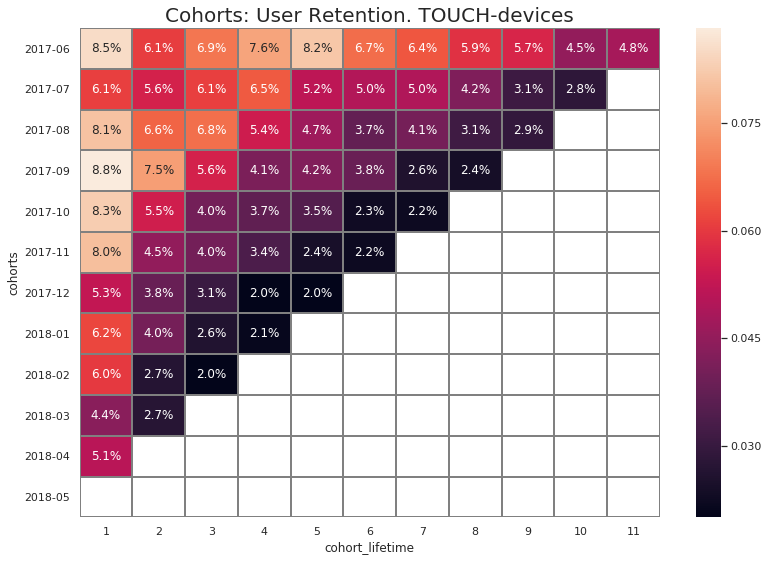

In [36]:
touch_retention_pivot = cohorts.query('device == "touch"').\
                            pivot_table(index='first_activity_month', 
                                        columns='cohort_lifetime', 
                                        values='retention')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention. TOUCH-devices', fontsize=20)
sns.heatmap(desktop_retention_pivot.iloc[:, 1:], annot=True, fmt='.1%', linewidths=1, linecolor='gray', 
            yticklabels = retention_pivot.index.strftime('%Y-%m'))
plt.ylabel('cohorts')

print('Средний показатель удержания пользователей Яндекс.Афиша во второй месяц на TOUCH-устройствах {:.1%}'.\
      format(touch_retention_pivot.iloc[:, 1].mean()))

Среднее значение Retantion Rate во второй период(месяц) жизненного цикла у всех когорт составил порядка 6,5%. На desktop-устройствах он незначительно выше (6,8% против 6,2% на touch-устройтсвах). 

Общая тенденция - Retention Rate снижается на протяжении жизненного цикла у всех когорт. 

Отметим, что первая когорта на всех типах устройств отличается более высоким показателем Retention Rate на протяжении 12 месяцев. При этом показатель удержания у первых шести когорот во второй период(месяц) заметно выше чем у последующих. В целом когорты начиная с '2017-12' характеризуются более низким показателем удержания в первые месяцы.

## Продажи <a id='section_6'></a>

### Когда люди начинают покупать? <a id='section_6'></a>

Сформируем датафрейм с первой датой сессии для каждого юзера

In [37]:
first_session = visits.groupby('uid')['start_ts'].min()
first_session.name = 'first_session'

Сформируем отдельный фрейм с датой первой покупки для каждого юзера, совершавшего покупки.

In [38]:
first_purchase = orders.groupby('uid')['buy_ts'].min().reset_index()
first_purchase.columns = ['uid', 'first_purchase']

Объединим в один датафрейм дату первой сессии и дату первой покупки по полю 'uid' и вычислим сколько проходит дней от даты первой сессии до совершения первого заказа. Построим гистограмму распределения.

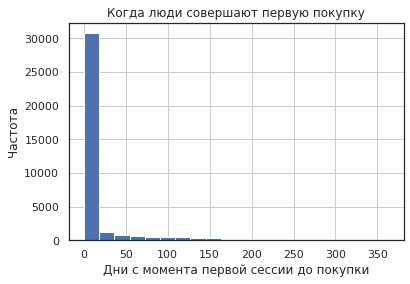

In [39]:
time_to_order = first_purchase.merge(first_session, on = 'uid')
time_to_order['time_to_first_purchase'] = pd.to_timedelta((time_to_order['first_purchase'] - time_to_order['first_session']).\
                                                          dt.days, unit='d') / np.timedelta64(1,'D')
time_to_order['time_to_first_purchase'].hist(bins=20)
plt.title('Когда люди совершают первую покупку')
plt.xlabel('Дни c момента первой сессии до покупки')
plt.ylabel('Частота')
plt.show()

In [40]:
print('Среднее количество дней от первой сессии до совершения покупки {:.0f} дней'.\
      format(int(time_to_order['time_to_first_purchase'].mode())))

Среднее количество дней от первой сессии до совершения покупки 0 дней


Более 70% совершают первый заказ с использованием сервиса Яндекс.Афиша в тот же день, в который совершают первое посещение сервиса.

### Сколько раз покупают за период? <a id='section_7'></a>

Т.к. в данных имеется единственная сессия с покупкой, выходящая за 12-месячный промежуток, удалим ее во избежание формирования неполной когорты

In [41]:
orders = orders[orders['buy_ts'] != '2018-06-01 00:02:00']

Выделим месяцы из дат c заказами и определим месяц первого заказа

In [42]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid')['order_month'].min().reset_index()
first_orders.columns = ['uid', 'first_order_month']
orders = orders.merge(first_orders, on='uid')

Посчитаме размер каждой когорты исходя из месяца первой покупки

In [43]:
cohort_sizes = first_orders.groupby('first_order_month')['uid'].nunique().reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

Присоединим к таблице с заказами данные о размерах когорт и добавим возраст когорт

In [44]:
orders = orders.merge(cohort_sizes, on='first_order_month')
orders['cohort_lifetime'] = (orders['order_month'] - orders['first_order_month']) / np.timedelta64(1, 'M') 
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')

Посмотрим как абсолютные показатели заказов когорт по периодам их существования

In [45]:
orders.pivot_table(index='first_order_month', columns='cohort_lifetime', values='uid', aggfunc='nunique')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0
2017-07-01,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,NaN
2017-08-01,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,NaN,NaN
2017-09-01,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,NaN,NaN,NaN
2017-10-01,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,NaN,NaN,NaN,NaN
2017-11-01,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,4383.0,146.0,103.0,97.0,50.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3373.0,114.0,83.0,43.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3651.0,118.0,58.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим как часто сколько в среднем покупатели совершают покупок в разрезе когорт

In [46]:
orders_grouped = orders.groupby(['first_order_month', 'cohort_lifetime'])['uid'].count().reset_index()
orders_grouped.columns = ['first_order_month', 'cohort_lifetime', 'n_orders']
orders_grouped = orders_grouped[orders_grouped['first_order_month'] != '2018-06-01']

orders_grouped = orders_grouped.merge(cohort_sizes, on='first_order_month')
orders_grouped['order_per_user'] = orders_grouped['n_orders'] / orders_grouped['n_buyers']
orders_grouped.head()

,first_order_month,cohort_lifetime,n_orders,n_buyers,order_per_user
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,177,2023,0.087494
2,2017-06-01,2,174,2023,0.086011
3,2017-06-01,3,226,2023,0.111715
4,2017-06-01,4,292,2023,0.144340


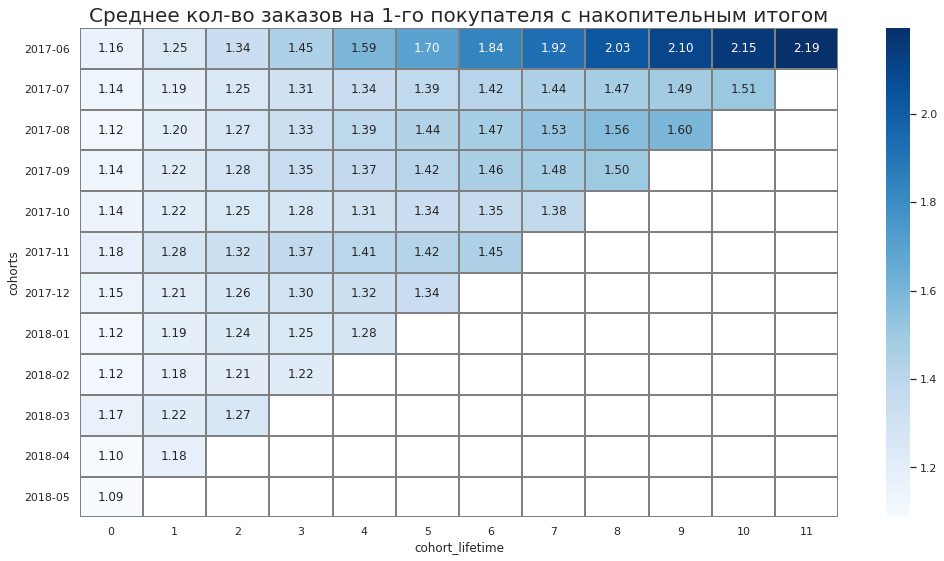

In [47]:
order_per_user = orders_grouped.pivot_table(index='first_order_month', columns='cohort_lifetime', values='order_per_user').cumsum(axis=1)
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Среднее кол-во заказов на 1-го покупателя с накопительным итогом', fontsize=20)
sns.heatmap(order_per_user, annot=True, fmt='.2f', linewidths=1, linecolor='gray', 
            yticklabels = order_per_user.index.strftime('%Y-%m'), cmap='Blues')
plt.ylabel('cohorts')
plt.show()

Для расчета среднего кол-ва заказов возьмем первые 7 месяцев, руководсвуясь тем, что при такой выборке в расчет попадает статистика по половине выделенных когорт.

In [48]:
print('В первые полгода пользователи Яндекс.Афиша совершают в среднем  {:.1f} заказа на сервисе '.\
      format(order_per_user.iloc[:7, 1].mean()))

В первые полгода пользователи Яндекс.Афиша совершают в среднем  1.2 заказа на сервисе 


На основании той же выборки из 7 когорт построим график изменения дохода в первые полгода существования когорт

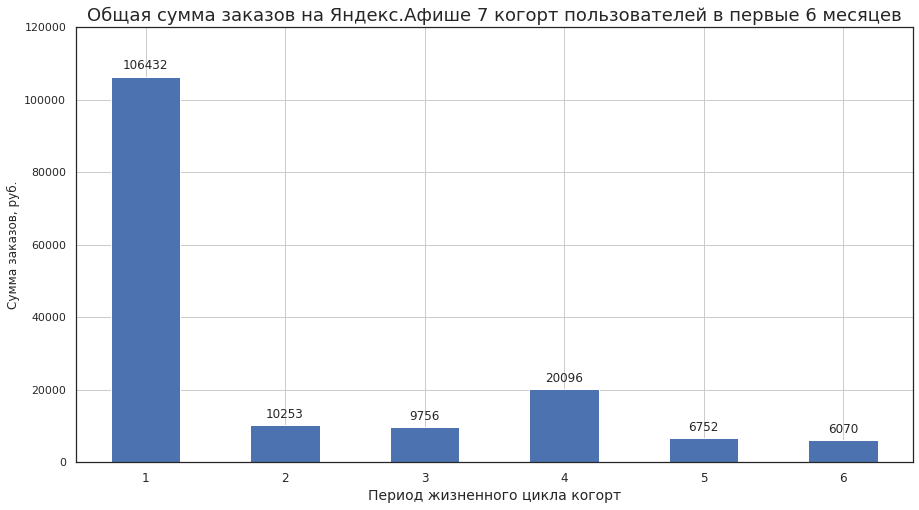

In [49]:
orders_grouped = orders[(orders['cohort_lifetime'] < 6) & (orders['first_order_month'] < '2018-01-01')].\
        groupby('cohort_lifetime')['revenue'].sum().reset_index()

orders_grouped.index = orders_grouped.index+1

ax = orders_grouped['revenue'].plot(kind='bar', grid=True, ylim=(0,120000), figsize=(15,8))
ax.set_title('Общая сумма заказов на Яндекс.Афише 7 когорт пользователей в первые 6 месяцев', fontsize=18)
ax.set_xticklabels(orders_grouped.index, rotation=0, fontsize=12)
ax.set_ylabel('Сумма заказов, руб.', fontsize=12)
ax.set_xlabel('Период жизненного цикла когорт', fontsize=14)

for i, sales in enumerate(orders_grouped.revenue):
    ax.text(i, sales+2000, int(sales), horizontalalignment='center', fontsize=12)

Очевидно, что в первый месяц жизненнего цикла когорт валовый доход является максимальным. Иными словами - доход обусловлен первым заказом, а последующее его падение - редкими повторными заказами. Но можно заметить, что на 4 месяц после первых заказов наблюдается небольшой всплеск, после чего падение продолжается. Это наводит на мысль, что какая-то значительная часть возвращается к повторным покупкам на 4-й месяц после первого заказа. Но данное допущение требует более детального анализа. Возможно, такой всплеск связан с ростом сезонного спроса в какой-то из когорт или имело место быть влияние других факторов.

### Средний чек <a id='section_8'></a>

Посчитаем средний чек по всем покупателям за все время, а также для отдельных платформ

In [50]:
user_device = visits.sort_values(by='start_ts').groupby('uid')['device'].first().reset_index()
orders = orders.merge(user_device, on = 'uid')

print('Средний чек по всем устройствам {:.2f} руб./заказ'.\
      format(orders['revenue'].mean()))
print('Средний чек по desktop-устройствам {:.2f} руб./заказ'.\
      format(orders.query('device == "desktop"')['revenue'].mean()))
print('Средний чек по touch-устройствам {:.2f} руб./заказ'.\
      format(orders.query('device == "touch"')['revenue'].mean()))

Средний чек по всем устройствам 5.00 руб./заказ
Средний чек по desktop-устройствам 5.16 руб./заказ
Средний чек по touch-устройствам 4.29 руб./заказ


Посчитаем средний чек в динамике по месяцам. Отобразим на графике общий показатель среднего чека.

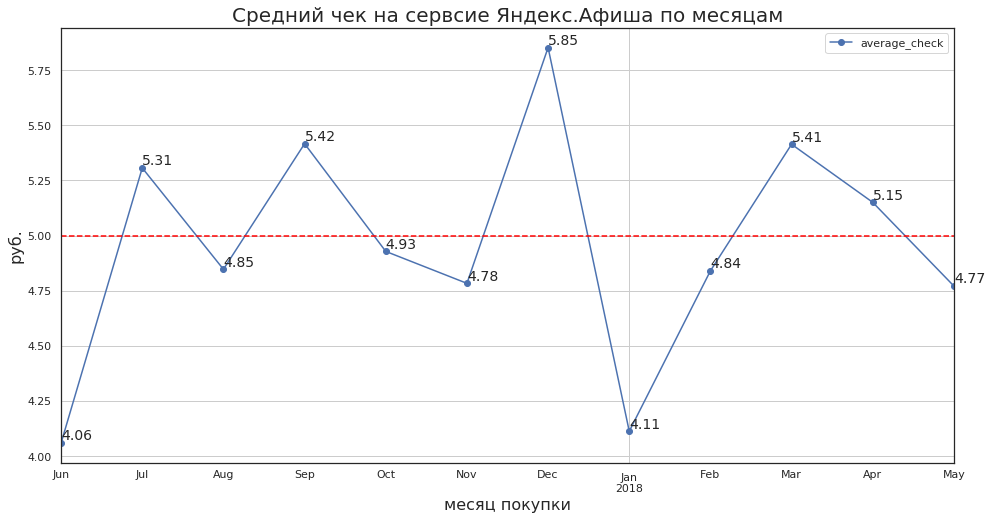

In [51]:
average_check = pd.DataFrame(orders.groupby('order_month')['revenue'].mean())

average_check = average_check.rename(columns = {'revenue':'average_check'})
ax = average_check.plot(figsize=(16,8), grid=True, style='-o')
ax.set_title('Средний чек на сервсие Яндекс.Афиша по месяцам', fontsize=20)
ax.set_ylabel('руб.', fontsize=16)
ax.set_xlabel('месяц покупки', fontsize=16)
plt.axhline(y=orders['revenue'].mean(), color='red', linestyle='--')

for row in average_check.itertuples():
    ax.text(row.Index, row.average_check, s=round(row.average_check, 2), horizontalalignment= 'left', verticalalignment='bottom', fontsize=14)

График демонстрирует нестабильность показателя среднего чека и хаотичные колебания во времени. Исходя из увиденного можно констатировать факт, что средний чек колеблется от 4 до 6 руб/заказ.

### Сколько денег приносят? (LTV) <a id='section_9'></a>

Привяжем к  каждому пользователю источник и добавим эту информацию к таблице с заказами

In [52]:
user_source = visits.sort_values(by='start_ts').groupby('uid')['source_id'].first().reset_index()
orders = orders.merge(user_source, on='uid')
orders.head()

,buy_ts,revenue,uid,order_month,first_order_month,n_buyers,cohort_lifetime,device,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2023,0,desktop,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2023,0,desktop,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2023,0,desktop,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2023,0,desktop,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2023,0,desktop,3


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа, посчитаем кол-во покупателей для каждой когорты, просуммируем выручку. 

In [53]:
report = orders.\
    groupby(['first_order_month', 'order_month', 'source_id'])[['n_buyers','revenue', 'cohort_lifetime']].\
    agg({'n_buyers':'mean', 'revenue':'sum','cohort_lifetime':'mean' }).reset_index()
report.head()

,first_order_month,order_month,source_id,n_buyers,revenue,cohort_lifetime
0,2017-06-01,2017-06-01,1,2023,1378.70,0
1,2017-06-01,2017-06-01,2,2023,1043.68,0
2,2017-06-01,2017-06-01,3,2023,2804.34,0
3,2017-06-01,2017-06-01,4,2023,1959.84,0
4,2017-06-01,2017-06-01,5,2023,1898.89,0


Для расчета LTV требуется значение валовой прибыли. Т.к. в исходных данных такая информация отсутствует, показатель маржинальности примем за 1. Таким образом выручка и будет являться валовой прибылью

In [54]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate

Приступим к расчету LTV

In [55]:
report['ltv'] = report['gp'] / report['n_buyers']
report.head()

,first_order_month,order_month,source_id,n_buyers,revenue,cohort_lifetime,gp,ltv
0,2017-06-01,2017-06-01,1,2023,1378.70,0,1378.70,0.681513
1,2017-06-01,2017-06-01,2,2023,1043.68,0,1043.68,0.515907
2,2017-06-01,2017-06-01,3,2023,2804.34,0,2804.34,1.386228
3,2017-06-01,2017-06-01,4,2023,1959.84,0,1959.84,0.968779
4,2017-06-01,2017-06-01,5,2023,1898.89,0,1898.89,0.938651


Визуализируем LTV виде сводной таблицы и тепловой карты

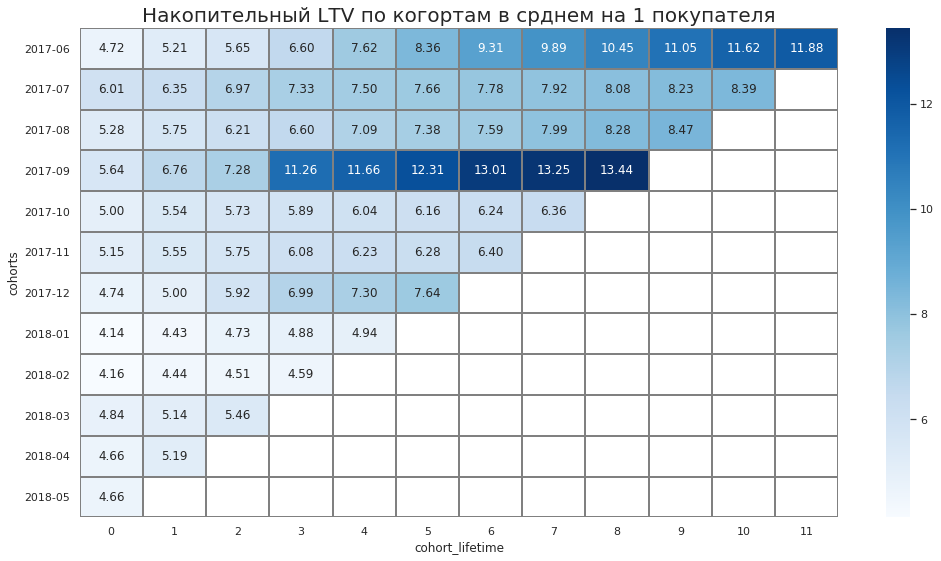

In [56]:
ltv_pivot = report.pivot_table(
            index = 'first_order_month',
            columns = 'cohort_lifetime',
            values = 'ltv',
            aggfunc= 'sum').cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Накопительный LTV по когортам в срднем на 1 покупателя', fontsize=20)
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', 
            yticklabels = ltv_pivot.index.strftime('%Y-%m'), cmap='Blues')
plt.ylabel('cohorts')
plt.show()

Для расчета LTV в разрезе источников включим в выборку когорты имеющие данные по заказам за полных 7 месяцев, руководсвуясь тем, что при такой выборке в расчет попадает статистика по половине выделенных когорт. Также исключим источник №7

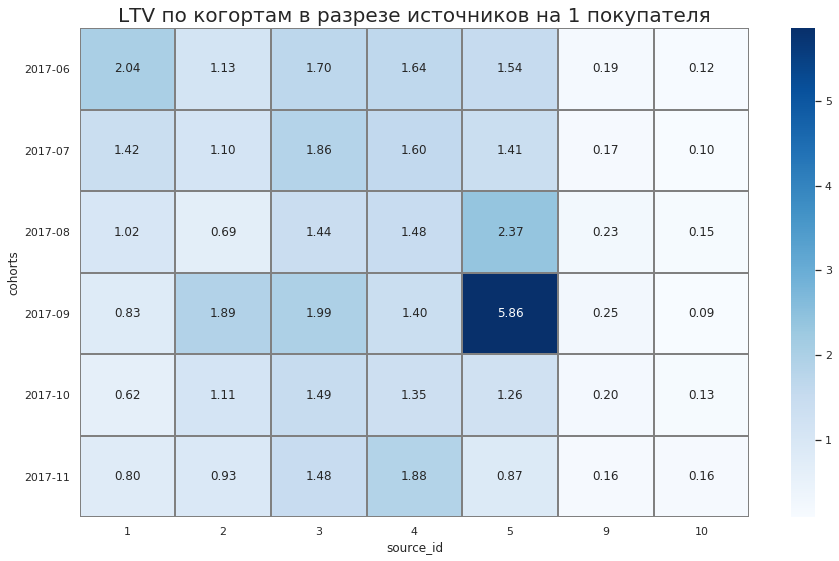

In [57]:
ltv_per_source = report[(report['cohort_lifetime'] < 6)
                                & (report['first_order_month'] < '2017-12-01')
                                & (report['source_id'] != 7)].\
                                pivot_table(index = 'first_order_month',
                                columns = 'source_id',
                                values = 'ltv',
                                aggfunc = 'sum')
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV по когортам в разрезе источников на 1 покупателя', fontsize=20)
sns.heatmap(ltv_per_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray', 
            yticklabels = ltv_per_source.index.strftime('%Y-%m'), cmap='Blues')
plt.ylabel('cohorts')
plt.yticks(rotation=0)
plt.show()

In [58]:
ltv_per_source.mean()

source_id
1     1.120967
2     1.142425
3     1.659221
4     1.559808
5     2.217454
9     0.200475
10    0.123410
dtype: float64

Особняком стоят покупатели 4 (2017-09) по счету когорты привлеченные из источника №5. Они принесли максимальную прибыль за первые 7 месяцев. Весомость этого источника можно отметить и для 3-й когорты (2017-08). Также можно отметить, что покупатели привлеченные из источников 9 и 10 наименее прибыльные, а источники 6-7 и вовсе не попали в анализ, т.к. заказы из них конвертируются крайне мало и не стабильно.

В остальных случаях основными рабочими источниками для привелечения покупателей LTV являются источники 1-5. Показатели LTV по ним распределены более-менее равномерно (за исключением выше описанных показателей) и удельный вес того или иного истоника имеет различные показатели в зависимоти от ислледуемой когорты.

## Маркетинг <a id='section_10'></a>

 ### Сколько денег потратили? Всего <a id='section_10'></a>

In [59]:
costs_sum = costs['costs'].sum()
revenue_sum = orders['revenue'].sum().round(2)

print('Суммарные затраты на маркетинг за 12 месяцев составили {:.2f} руб:'.format(costs_sum))
print('Суммарная валовая прибыль за 12 месяцев составила {:.2f} руб:'.format(revenue_sum))
print('Прибыльность проекта {:.1%}:'.format(revenue_sum / costs_sum - 1))

Суммарные затраты на маркетинг за 12 месяцев составили 329131.62 руб:
Суммарная валовая прибыль за 12 месяцев составила 252053.78 руб:
Прибыльность проекта -23.4%:


На текущий момент затраты на маркетинг не окупились. Однако, мы допускаем не мгновенную окупаемость маркетинговых затрат. Проанализируем ситуацию более детально для понимания средних сроков окупаемости и сумм инвестиций во времени.

 ### Сколько денег потратили? На каждый источник

In [60]:
costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index().\
                            sort_values(by='costs', ascending=False)
costs_per_source

,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


Источник №3 является наиболее затратным, в то время как на 9 и 10 источники тратят совсем немного, что соотносится с показателем LTV из этих источников, расчитанным выше.

 ### Сколько денег потратили? По времени

Text(0.5, 0, 'месяц')

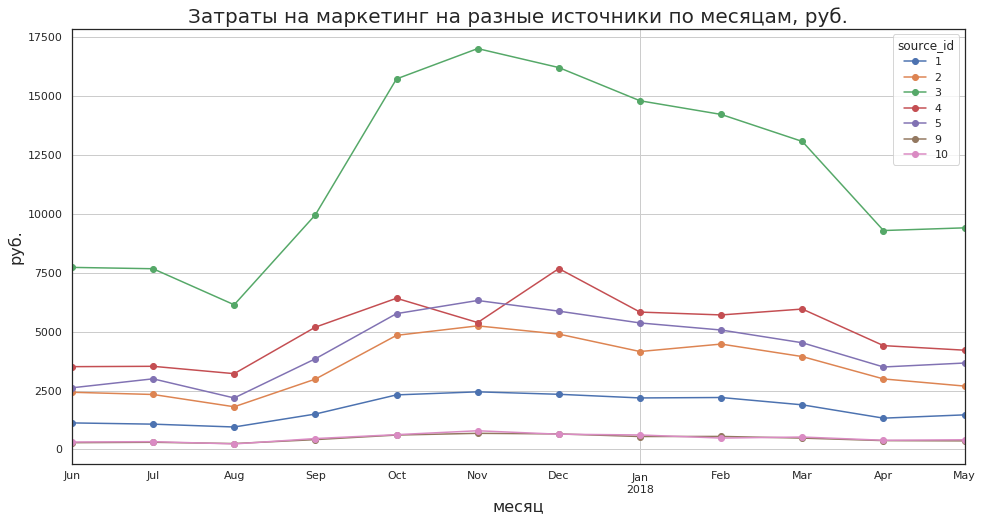

In [61]:
costs['month'] = costs['date'].astype('datetime64[M]')
costs_per_month = costs.pivot_table(index='month', 
                                    columns='source_id', 
                                    values='costs',  
                                    aggfunc='sum')

ax = costs_per_month.plot(figsize=(16,8), grid=True, style='-o')
ax.set_title('Затраты на маркетинг на разные источники по месяцам, руб.', fontsize=20)
ax.set_ylabel('руб.', fontsize=16)
ax.set_xlabel('месяц', fontsize=16)

Волатильность затрат по всем, за исключением источника №3 не высокая.

По источнику №3 заметен резкий рост затрат начиная с октября 2017-го. Относительно высокие затраты по этому источнику продолжаются вплоть до марта 2018-го. Остальные источники также демонстрируют рост затрат на них, однако он не столь заметен.

Судя по всем маркетологи делают ставку на источник №3 как основной для привлечения покупателя с диверсификацией затрат также на источники 4-5-2, в меньшей степени на 1-9-10. (Все источники указаны в порядке убывания затрат на них.)

### CAC. Сколько стоило привлечение одного покупателя из каждого источника? <a id='section_11'></a>

Посчитаем среднее значение метрики CAC

In [62]:
CAC = costs_sum / orders['uid'].nunique()
print('Стоимость привлечения одного покупателя {:.2f} руб.'.format(CAC))

Стоимость привлечения одного покупателя 9.01 руб.


In [63]:
monthly_costs = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()
report_new = report.merge(monthly_costs, left_on = ['first_order_month', 'source_id'], right_on=['month', 'source_id'])
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

display(monthly_costs.head())
display(report_new.head())

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


,first_order_month,order_month,source_id,n_buyers,revenue,cohort_lifetime,gp,ltv,month,costs,cac
0,2017-06-01,2017-06-01,1,2023,1378.70,0,1378.70,0.681513,2017-06-01,1125.61,0.556406
1,2017-06-01,2017-07-01,1,2023,414.98,1,414.98,0.205131,2017-06-01,1125.61,0.556406
2,2017-06-01,2017-08-01,1,2023,419.43,2,419.43,0.207331,2017-06-01,1125.61,0.556406
3,2017-06-01,2017-09-01,1,2023,714.24,3,714.24,0.353060,2017-06-01,1125.61,0.556406
4,2017-06-01,2017-10-01,1,2023,811.20,4,811.20,0.400989,2017-06-01,1125.61,0.556406


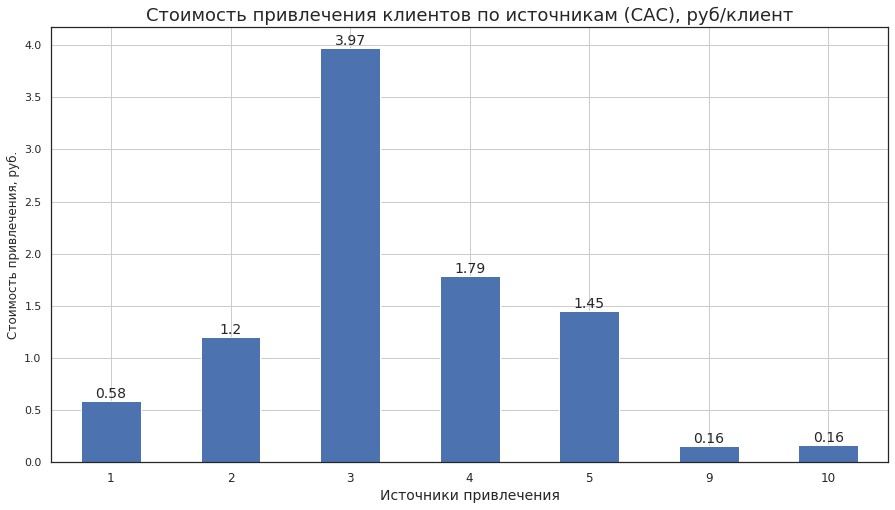

In [64]:
cac_per_source = report_new.pivot_table(index = 'source_id',
                       #columns = 'month', 
                       values = 'cac',
                       aggfunc = 'mean').reset_index()


ax = cac_per_source['cac'].plot(kind='bar', grid=True, figsize=(15,8))
ax.set_title('Стоимость привлечения клиентов по источникам (CAC), руб/клиент', fontsize=18)
ax.set_xticklabels(cac_per_source.source_id, rotation=0, fontsize=12)
ax.set_ylabel('Стоимость привлечения, руб.', fontsize=12)
ax.set_xlabel('Источники привлечения', fontsize=14)

for row in cac_per_source.itertuples():
    ax.text(row.Index, row.cac, s=round(row.cac, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

Как видно из графика, наиболее дорогим по привдечению оказывается клиент из источника №3. В дальнейшем посмотрим является ли это эффективной мерой привлечения. 

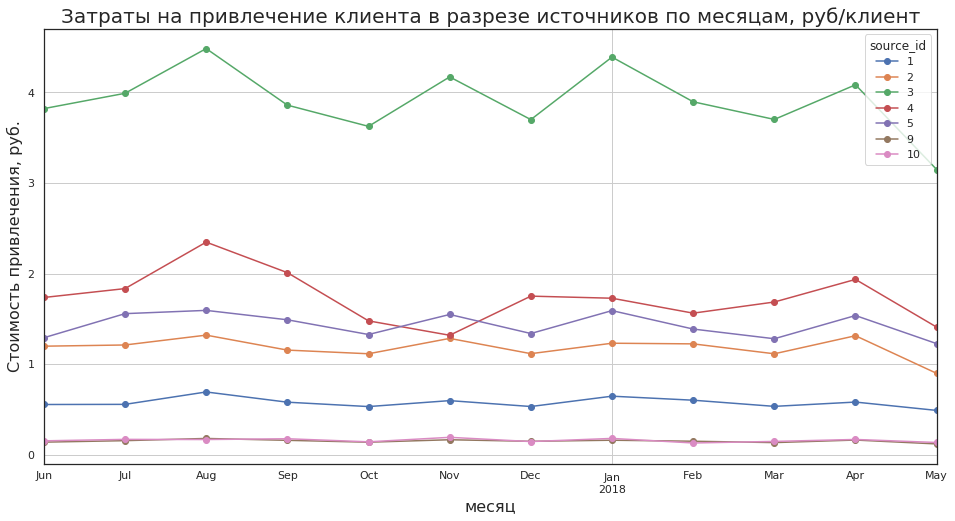

In [65]:
cac_per_month = report_new.pivot_table(index = 'month',
                       columns = 'source_id', 
                       values = 'cac',
                       aggfunc = 'mean')

ax = cac_per_month.plot(figsize=(16,8), grid=True, style='-o')
ax.set_title('Затраты на привлечение клиента в разрезе источников по месяцам, руб/клиент', fontsize=20)
ax.set_ylabel('Стоимость привлечения, руб.', fontsize=16)
ax.set_xlabel('месяц', fontsize=16)
plt.show()


Во времени есть колебания по стоимости привлечения клиента, однако они незначительны. При этом источник №3 остается самым дорогим по привлечению на протяжение всего времени.

### На сколько окупились расходы? (ROI) <a id='section_12'></a>

Сформируем датафрем для корректного анализа маркетинговых инвестиций на привлечение новых клиентов. На основании него построим тепловую карту.

,first_order_month,cohort_lifetime,ltv,cac,romi
0,2017-06-01,0,4.724414,8.905091,0.530530
1,2017-06-01,1,0.485329,8.905091,0.054500
2,2017-06-01,2,0.437637,8.749768,0.050017
3,2017-06-01,3,0.954671,8.749768,0.109108
4,2017-06-01,4,1.022531,8.749768,0.116864


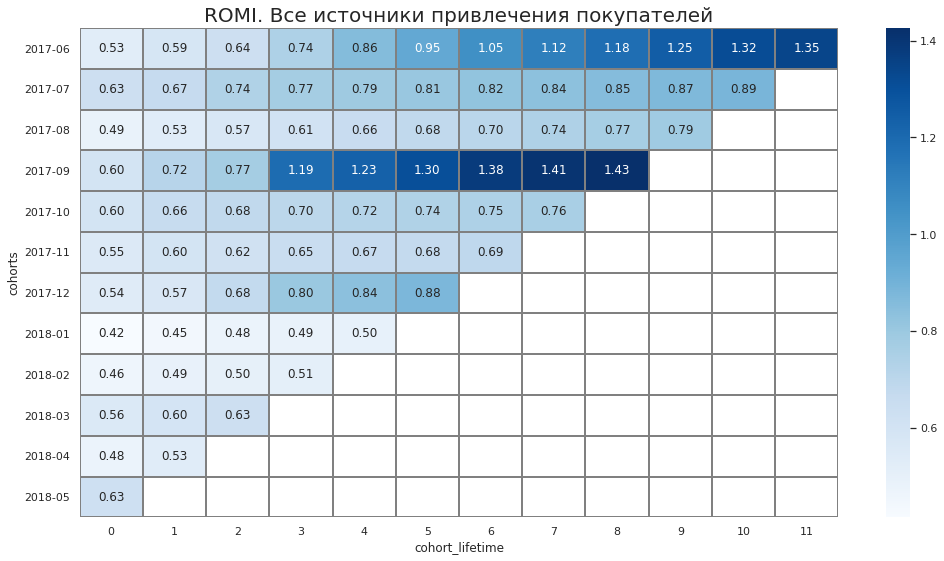

In [66]:
report_total_romi = report_new.groupby(['first_order_month', 'cohort_lifetime'])['ltv','cac'].sum().reset_index().\
                    assign(romi = lambda x: x['ltv'] / x['cac'])

display(report_total_romi.head())

output = report_total_romi.pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1)

plt.figure(figsize=(17, 9))
sns.set(style='white')
plt.title('ROMI. Все источники привлечения покупателей', fontsize=20)
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray', 
            yticklabels = ltv_pivot.index.strftime('%Y-%m'), cmap='Blues')
plt.ylabel('cohorts')
plt.show()

In [67]:
output.mean(axis=0)

cohort_lifetime
0     0.540809
1     0.582065
2     0.631451
3     0.720731
4     0.784509
5     0.862108
6     0.899315
7     0.973233
8     1.058082
9     0.969682
10    1.101975
11    1.346655
dtype: float64

Окупаемость инвестиций в маркетинг наблюдается только у 2 их 12 когорт:
- у когорты 2017-06-01 - окупаемость наступила спустя 6 месяцев
- у когорты 2017-09-01 - окупаемость наступила на 4-й месяц

В среднем когорты окупаются к концу 9 месяца. Это объясняет отрицательные показатели валовой прибыли. Необходим более детальный анализ затрат в разрезе источников, поиск неэффективных источников привлечения клиентов.

Расчитаем показатель ROMI в датафрейме для каждой когорты покупателей с учетом источников привлечения.

In [68]:
report_new['romi'] = report_new['ltv'] / report_new['cac']

С помощью цикла сформируем тепловую карту ROMI для каждого из источников привлечения покупателей. Малоиспользуемые источники в расчет не берем.

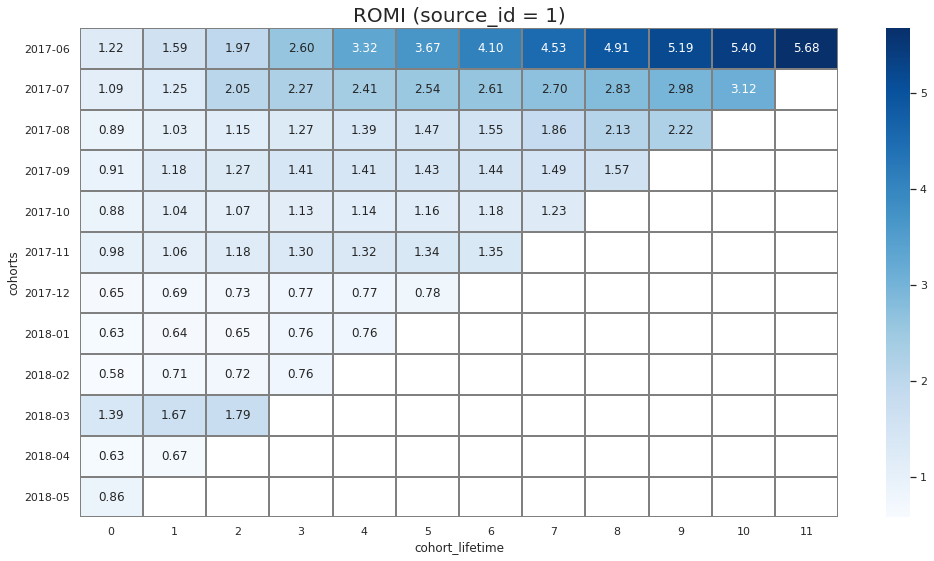

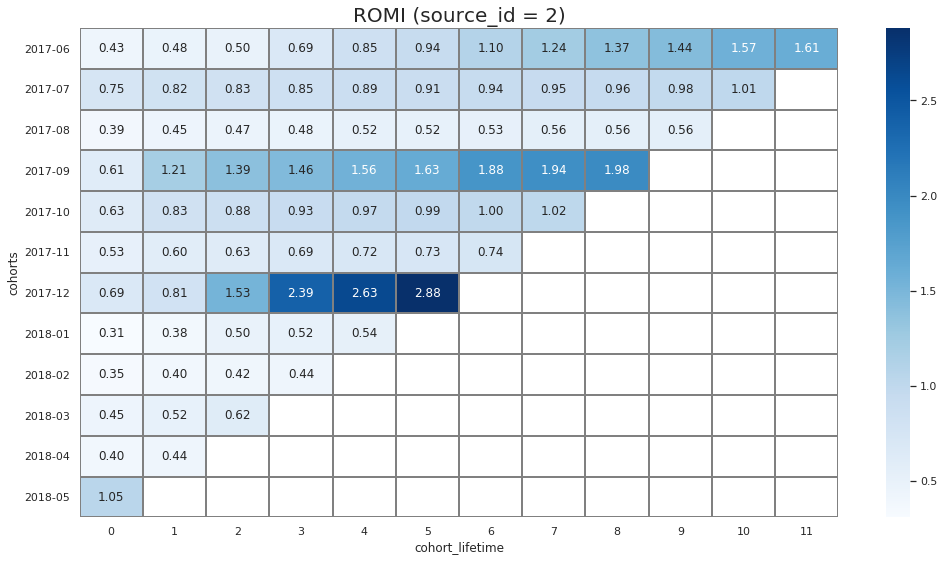

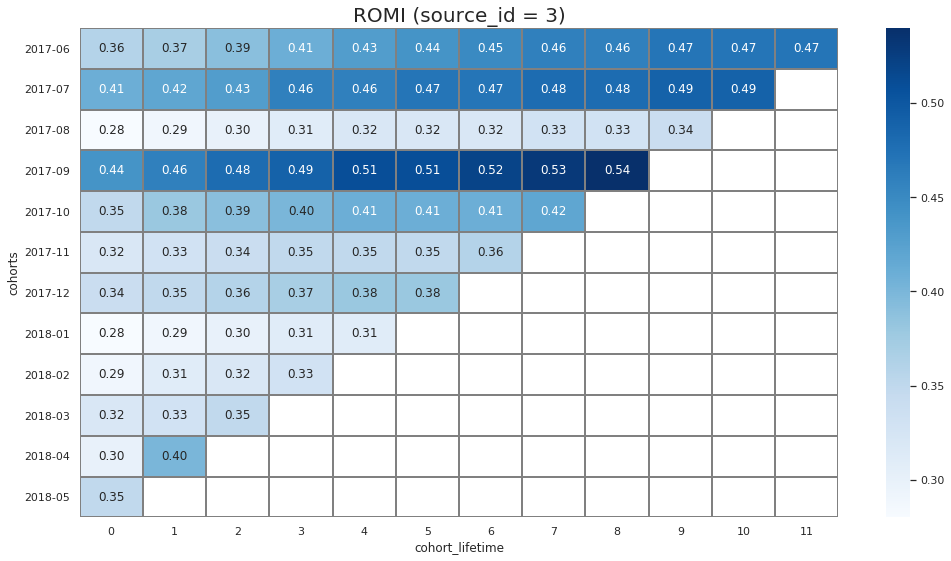

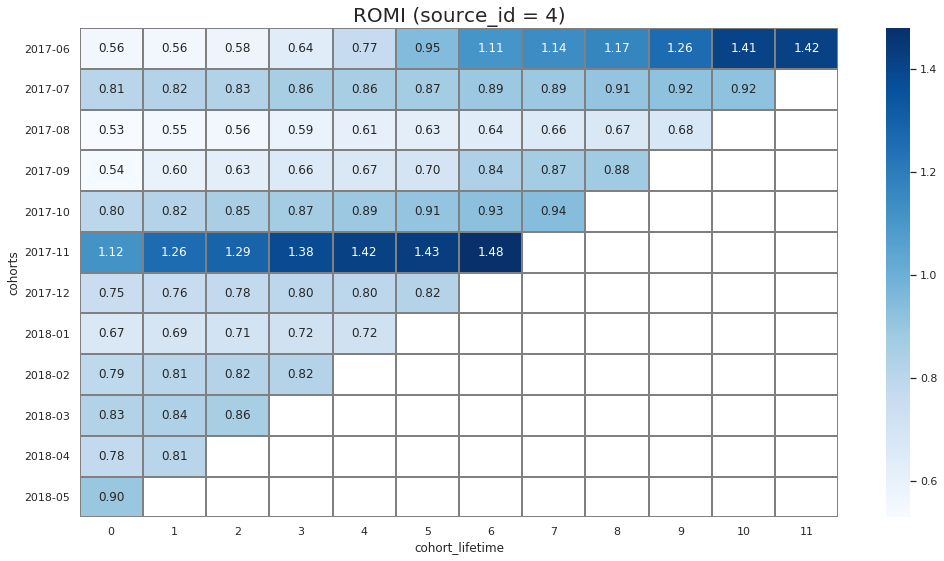

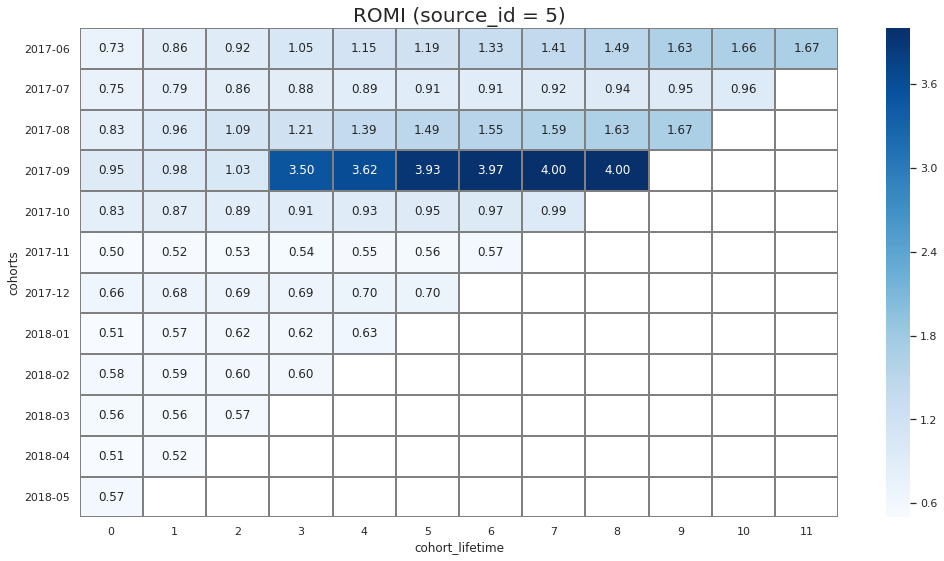

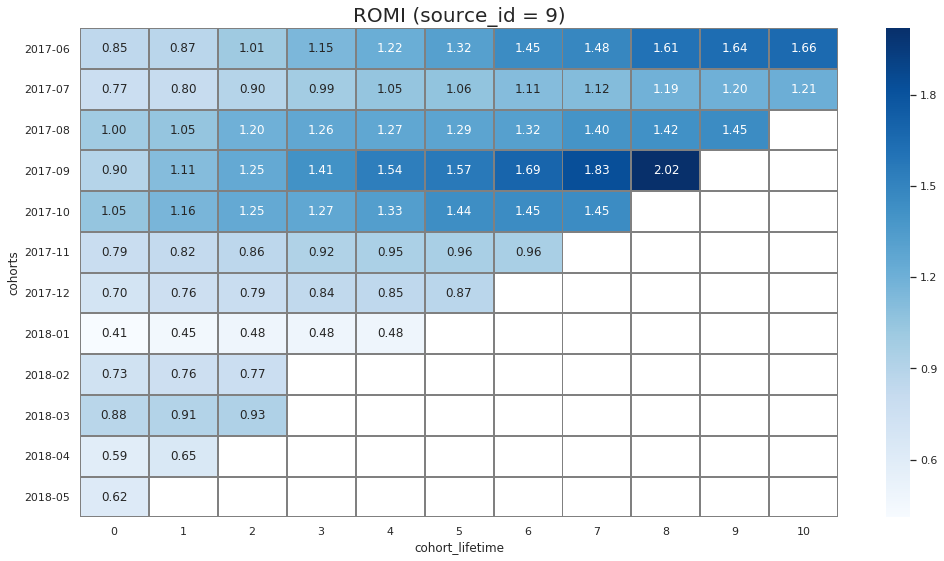

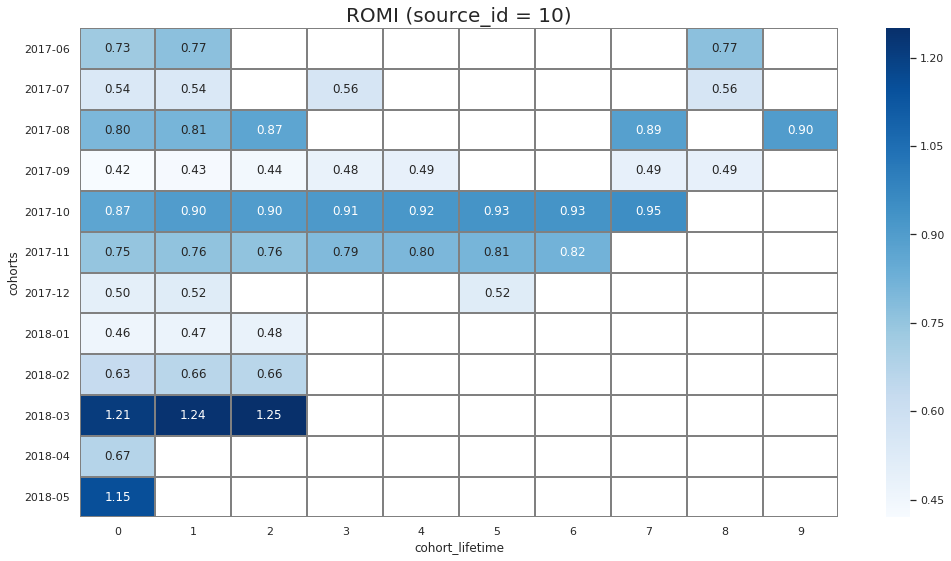

In [69]:
for source in [1, 2, 3, 4, 5, 9, 10]:
    romi_source = report_new.query('source_id == @source').\
        pivot_table(index='first_order_month', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)
    
    plt.figure(figsize=(17, 9))
    sns.heatmap(romi_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray', 
            yticklabels = romi_source.index.strftime('%Y-%m'), cmap='Blues')
    sns.set(style='white')
    plt.title('ROMI (source_id = {})'.format(source), fontsize=20)
    plt.ylabel('cohorts')
    
plt.show()

Выясним средний месяц окупаемости для каждого из источников

In [70]:
for source in [1, 2, 3, 4, 5, 9, 10]:
    romi_source = report_new.query('source_id == @source').\
        pivot_table(index='first_order_month', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2).mean().reset_index()
    try:
        print('Источник {}: средний месяц окупаемости - {}'.\
                format(source, romi_source[romi_source[0] > 1]['cohort_lifetime'].iloc[0]+1))
    except:
        print('Источник {} не окупается'.format(source))

Источник 1: средний месяц окупаемости - 2
Источник 2: средний месяц окупаемости - 5
Источник 3 не окупается
Источник 4: средний месяц окупаемости - 11
Источник 5: средний месяц окупаемости - 4
Источник 9: средний месяц окупаемости - 4
Источник 10 не окупается


Средние показатели LTV по источникам

In [71]:
ltv_per_source.mean()

source_id
1     1.120967
2     1.142425
3     1.659221
4     1.559808
5     2.217454
9     0.200475
10    0.123410
dtype: float64

## Выводы и рекомендации <a id='section_13'></a>

В ходе исследования эффективности используемых рекламных источников выявлены источники, вызывающие вопросы эффективности привлечения новых клиентов.

Первое, на что хочется обратить внимание - это **Источник 3**:
- При максимальной стоимости привлечения одного клиента (CAC) - почти 4 руб./клиент;
- Худший показатель ROMI - ни одна из когорт не продемонстироровала окупаемость за рассматриваемый период, несмотря на относительно высокий LTV.
- При самом высоком бюджете, второй источник по привлечению посетителей.
- Необходим пересмотр параметров использования источника 3 с целью снижения затрат на привлечений одного клиента и/или перераспределение бюджета в пользу других источников:

**Источник 1**
Демонстрирует быструю окупаемость на 2-й месяй после привлечения, но показатель LTV один из самых низких

**Источник 5**
Показывает наиболее сбалансированную выгоду привлечения клиента. Срок окупаемости 4 меясца. Максимальный показатель LTV. И средняя стоимость привлечения.

**Источник 4**
Лидирует по привлечению пользователей на сервис Яндекс.Афиша, из недостатков - продолжительная окупаемость - 11 месяцев.

Предлагаем отделу маркетинга рассмотреть возможность перераспределения рекламного бюджета в пользу 5 и 1 источников и пересмотреть затраты на 3 источник.

Рекомендации по части платформ:
- акцент на пользователях на desktop-платформах - они по-прежнему в большинстве, показатель среднего чека на 20% выше, проводят больше времени на сервсие Яндекс.Афиша и немного чаще возвращаются.